In [1]:
pip install xlrd==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 932.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Scraping Excel Data with Python along row and column

One of the most challenging data wrangling tasks I encountered was dealing with manual data stored in disparate Excel files. There were tens of Excel files stored in one directory, each file contained hundreds of sheets. The mission at hand: collect only necessay information from the hundreds of Excel files and create a data frame.

I hope this will help you if you are trying scrap data from non-standard formated excel file. 

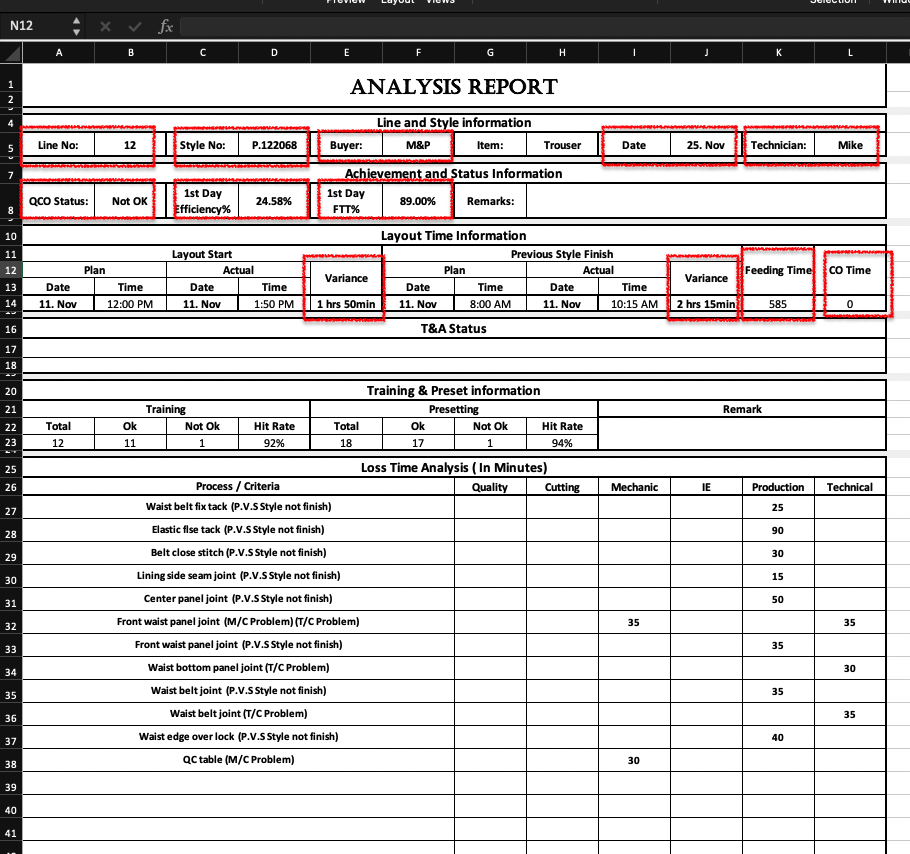

In [2]:
from IPython.display import Image
Image('../input/mockdata-image/Screenshot 2022-06-19 at 20.43.10.png')

# Problem 
**Here is a screenshot of one sheet. My job was to collect information from the red marked cells. As we can see that some of the data was positioned in the next column to their attribute, while other was positioned down in the next row.
So, here is how I srapped tens of excel file with hundreds of sheets. (For company privacy, here I used only 2 mock files)**

#### Importing packages

In [3]:
import os
import pandas as pd
import xlrd
import numpy as np

print(os.getcwd())

/kaggle/working


In [4]:
os.chdir('../input/mockdata')

In [5]:
print(os.getcwd())

/kaggle/input/mockdata


In [6]:
wb = xlrd.open_workbook('Excel_file_1.xlsx')
print(wb)

In [7]:
#To get sheet by index (starts with 0)
ws = wb.sheet_by_index(0)

#To get sheet by name 
ws = wb.sheet_by_name('Sheet1')

In [8]:
#get list of values in row
ws.row_values(4)

['Line No:',
 12.0,
 'Style No:',
 'POPY JOGGER',
 'Buyer:',
 'MOONSOON',
 'Item:',
 'Trouser',
 'Date',
 40316.0,
 'Technician:',
 'John']

In [9]:
#get list of values in column
ws.col_values(0)

['Analysis Report',
 '',
 '',
 'Line and Style information',
 'Line No:',
 '',
 'Achievement and Status Information',
 'QCO Status:',
 '',
 'Layout Time Information',
 'Layout Start',
 'Plan',
 'Date',
 40316.0,
 '',
 'T&A Status',
 '',
 '',
 '',
 'Training & Preset information',
 'Training',
 'Total',
 11.0,
 '',
 'Loss Time Analysis ( In Minutes)',
 'Process / Criteria',
 'Pocket decrotion (Oproter not skill)  (T/C Problem)',
 'Front panel top stitch (Feeding slow L/C )',
 'Mark for pocket  (T/C Problem)',
 'Pocket joint (Feeding slow L/C )',
 'Pocket mark (Feeding slow L/C )',
 'Pocket joint (Oproter not skill)  (T/C Problem)',
 'Waist belt joint  (T/C Problem)',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Total',
 'Grand Total',
 '',
 'Top Reasons of Failure or Difficulties',
 'Skill and capacity issue',
 'Production /Quality',
 '',
 '',
 '',
 '',
 '',
 '',
 'Signature Panel',
 '',
 '',
 'Production']

## Get value from next column of attribute

In [10]:
attributes = ws.col_values(0)
attribute_index = attributes.index('Line No:')

#get the neighboring value output of the attribute
values = ws.col_values(1)
values[attribute_index]

12.0

## Get value down from next row of attribute

In [11]:
attributes = ws.col_values(0)
attribute_index = attributes.index('Date')

#get the next row value output of the attribute
values = ws.col_values(0)
values[attribute_index+1] # +1 for new row

40316.0

## Fixing datetime format 

In [12]:
import datetime
attributes = ws.col_values(8)
attribute_index = attributes.index('Date')

#get the neighboring value output of the attribute
values = ws.col_values(9)
v= datetime.datetime(*xlrd.xldate_as_tuple(values[attribute_index], 0))
print(v)

2010-05-18 00:00:00


## Function: Get value from next column of attribute

In [13]:
def get_value_nc(worksheet, attribute_column, attribute_name):
    attributes = worksheet.col_values(attribute_column)
    if attribute_name in attributes:
        if attribute_name == 'Date':
            attribute_index = attributes.index(attribute_name)

            values = worksheet.col_values(attribute_column+1) #value is in the adjacent column where attribute is stored
            try:
                value = datetime.datetime(*xlrd.xldate_as_tuple(values[attribute_index], 0))
                return value
            except:
                return 'None'
            
        else:
            attribute_index = attributes.index(attribute_name)

            values = worksheet.col_values(attribute_column+1) #value is in the adjacent column where attribute is stored
            value = values[attribute_index]
            return value
    else:
        return np.nan
        
get_value_nc(ws,8,'Date')

datetime.datetime(2010, 5, 18, 0, 0)

## Function: Get value down from next row of attribute

In [14]:
def get_value_nr(worksheet, attribute_column, attribute_name):
    attributes = worksheet.col_values(attribute_column)
    if attribute_name in attributes:
        if attribute_name == 'Variance':
            attribute_index = attributes.index(attribute_name)
            values = worksheet.col_values(attribute_column)
            value= values[attribute_index+2] # +2 for Varience as in excel 2 rows marged
            return value
        elif attribute_name in ['Feeding Time','CO Time']:
            attribute_index = attributes.index(attribute_name)
            values = worksheet.col_values(attribute_column)
            value= values[attribute_index+3] # +3 for Feeding Time and CO Time as in excel 3 rows marged
            return value
        else: 
            attribute_index = attributes.index(attribute_name)
            values = worksheet.col_values(attribute_column)
            value= values[attribute_index+1] # +1 for the rest
            return value
    else:
        return np.nan
        
print(get_value_nr(ws,9,'Variance'))
print(get_value_nr(ws,10,'Feeding Time'))

3 hrs 20min
440.0


In [15]:
attributes = ['Line No:', 'QCO Status:']

data = {attribute: [] for attribute in attributes} # Empty Dictionary for storing data

for attribute in attributes:
    data[attribute].append(get_value_nc(ws,0,attribute))
data

{'Line No:': [12.0], 'QCO Status:': ['Not OK']}

### List of item that we will search value at the next column
I used dictionay format where key is the column number, and value is the list of item that we will search in that column

In [16]:
search_item_c={0: ['Line No:', 'QCO Status:'],
             2:['Style No:','1st Day Efficiency%'],
             4:['Buyer:','1st Day FTT%'],
             8:['Date'],
             10:['Technician:']} # key is the column number (starting from 0) at excel file.

In [17]:
search_item_c.values()

dict_values([['Line No:', 'QCO Status:'], ['Style No:', '1st Day Efficiency%'], ['Buyer:', '1st Day FTT%'], ['Date'], ['Technician:']])

### List of item that we will search value down at the next row

In [18]:
search_item_r={4:['Variance'],
               9:['Variance'],
               10:['Feeding Time'], 
               11: ['CO Time']} # key is the column number (starting from 0) at excel file.

## Function: Scrapping/Reading one sheet of an Excel workbook. 

In [19]:
def read_sheet(sheet_name, work_book):
    '''
    sheet_name --> str. Name of the sheet
    work_book  --> Excel Workbook file. for example:
                                             work_book = xlrd.open_workbook(file path)
                                             
    This function returns a DataFrame containing srcaped data from one sheet
    '''
    work_sheet= work_book.sheet_by_name(sheet_name)
    dic = {}
    for col in search_item_c.keys():
        for attribute in search_item_c[col]:
            dic[attribute] = [get_value_nc(work_sheet,col,attribute)]  # Called 'get_value_nc' function
    for col in search_item_r.keys():
        for attribute in search_item_r[col]:
            dic[attribute] = [get_value_nr(work_sheet,col,attribute)]  # Called 'get_value_nr' function
    dic['sheet_name']= sheet_name
    df = pd.DataFrame.from_dict(dic)
    return df 



**List of Excelfiles in currect directory. Please make sure there is no other file in current folder**

In [20]:
# List of Excelfiles in currect directory

files = os.listdir()
files

['Excel_file_1.xlsx', 'Excel_file_2.xlsx']

## Loop and Scrap from all the Excel file and sheets

In [21]:
df_total= pd.DataFrame() # redefining empty DataFrame to avoid repeatation
for file in files:
    work_book = xlrd.open_workbook(file)
    sheet_names= work_book.sheet_names()
    for sheet_name in sheet_names:
        df = read_sheet(sheet_name, work_book) # called 'read_sheet' Function
        df_total=df_total.append(df)
df_total

,Line No:,QCO Status:,Style No:,1st Day Efficiency%,Buyer:,1st Day FTT%,Date,Technician:,Variance,Feeding Time,CO Time,sheet_name
0,12.0,Not OK,POPY JOGGER,0.245767,MOONSOON,0.89,2010-05-18,John,3 hrs 20min,440.0,95.0,Sheet1
0,12.0,Not OK,P.122068,0.245767,M&P,0.89,2021-11-25,Mike,2 hrs 15min,585.0,0.0,Sheet2
0,2.0,Not OK,Vanja,0.245767,C&S,0.89,2010-07-27,Mike,1 hrs 45min,605.0,290.0,Sheet1


In [22]:
df_total.isna()

,Line No:,QCO Status:,Style No:,1st Day Efficiency%,Buyer:,1st Day FTT%,Date,Technician:,Variance,Feeding Time,CO Time,sheet_name
0,False,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,False,False


**Althugh there are no empty values in this example, in my case where I had to scrap from thousands of sheets there are *empty string* in the DataFrame instead of *np.nan*. So I had to replace *epmty str* with *np.nan* before I apply *DataFrame.dropna()* function**

In [23]:
df_total.replace('', np.nan, inplace=True)
df_total

,Line No:,QCO Status:,Style No:,1st Day Efficiency%,Buyer:,1st Day FTT%,Date,Technician:,Variance,Feeding Time,CO Time,sheet_name
0,12.0,Not OK,POPY JOGGER,0.245767,MOONSOON,0.89,2010-05-18,John,3 hrs 20min,440.0,95.0,Sheet1
0,12.0,Not OK,P.122068,0.245767,M&P,0.89,2021-11-25,Mike,2 hrs 15min,585.0,0.0,Sheet2
0,2.0,Not OK,Vanja,0.245767,C&S,0.89,2010-07-27,Mike,1 hrs 45min,605.0,290.0,Sheet1


In [24]:
df_total.dropna(subset=['Line No:','Style No:'], inplace=True)

In [25]:
df_total.sort_values('Date')

,Line No:,QCO Status:,Style No:,1st Day Efficiency%,Buyer:,1st Day FTT%,Date,Technician:,Variance,Feeding Time,CO Time,sheet_name
0,12.0,Not OK,POPY JOGGER,0.245767,MOONSOON,0.89,2010-05-18,John,3 hrs 20min,440.0,95.0,Sheet1
0,2.0,Not OK,Vanja,0.245767,C&S,0.89,2010-07-27,Mike,1 hrs 45min,605.0,290.0,Sheet1
0,12.0,Not OK,P.122068,0.245767,M&P,0.89,2021-11-25,Mike,2 hrs 15min,585.0,0.0,Sheet2


## Save file to Excel

In [26]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
df_total.sort_values('Date').to_excel("/kaggle/working/Scraped_Data.xlsx", index=False)

### Leave an commment if you find this helpful.